# Makemore 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
torch_seed = 2147483647

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(torch_seed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 27.8817
  10000/ 200000: 2.9231
  20000/ 200000: 2.5788
  30000/ 200000: 2.8875
  40000/ 200000: 2.0839
  50000/ 200000: 2.4431
  60000/ 200000: 2.4559
  70000/ 200000: 2.1325
  80000/ 200000: 2.3324
  90000/ 200000: 2.3568
 100000/ 200000: 2.0748
 110000/ 200000: 2.4009
 120000/ 200000: 1.9218
 130000/ 200000: 2.4641
 140000/ 200000: 2.2747
 150000/ 200000: 2.1304
 160000/ 200000: 2.1510
 170000/ 200000: 1.7974
 180000/ 200000: 1.9913
 190000/ 200000: 1.8918


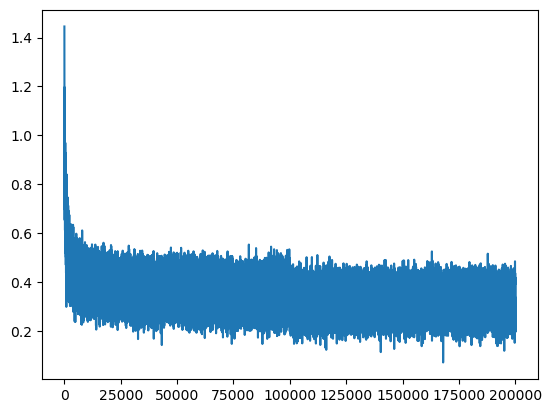

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.127152919769287
val 2.173154830932617


In [11]:
split_loss('train')

train 2.127152919769287


In [12]:
# sample from the model
g = torch.Generator().manual_seed(torch_seed)

for _ in range(20):
    out = []
    context = [0] * block_size # initalize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h@ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

dexze.
moglynn.
rochi.
ahnes.
jimmana.
nella.
kama.
aristaithuelthariiotom.
moriella.
kinz.
teda.
kaley.
maside.
enkavion.
roslst.
hani.
gavtahlan.
kashra.
anell.
pynn.


In [13]:
context = [1, 2, 3, 4, 5]
context[1:]

[2, 3, 4, 5]

This completes our trigram model.

This will be the starting point for this notebook. There are multiple things wrong in this model configuration and we'll be fixing them one by one in this notebook.

## Initial loss

The inital loss is 27.8817 and it rapidly comes down to 1 or 2 and this initial loss is really high.

For this problem setup, There's 27 characters that could come next and at initialisation of model the probabality that any of these characters will come next is same which is uniform distribution.

And probabality for each character will be 1/27.0

In [14]:
# Is the intial loss we should get
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Problem

At initialization, the model assigns varaible probablity instead of uniform probabality to all characters which it should. Probabality distributions are all messed up and for some characters it's really confident and for other characters not so much.

To sum up, Model is confidently wrong.

In [15]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Logits are uniform, so we get the correct loss. But what if logits varied.

In [16]:
# lucked out at initialisation and we get a really good loss
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [17]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

When the logits come out and have random extreme values, we record a high loss.

In [18]:
# with randn
logits = torch.randn(4)
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-2.0227, -0.1965,  1.8241, -0.4619]),
 tensor([0.0170, 0.1056, 0.7964, 0.0810]),
 tensor(0.2276))

Since the values are near zero loss that comes out is good. but incresing logits by ten fold.

In [19]:
# with randn by tenfold
logits = torch.randn(4) * 10
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-14.5781,  -2.2748,  -7.4133,   2.5850]),
 tensor([3.4899e-08, 7.6922e-03, 4.5128e-05, 9.9226e-01]),
 tensor(10.0060))

In [20]:
# with randn by hundredfold
logits = torch.randn(4) * 100
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([  12.3241, -100.9014,   55.3448,   50.0950]),
 tensor([2.0609e-19, 0.0000e+00, 9.9478e-01, 5.2213e-03]),
 tensor(0.0052))

We get really bad losses for extreme logits.

This is not good and what we want logits to be roughly zero or equal(uniform) at initialisation.

Let's write some code for getting paramters, and training the model since we'll repeat them a lot.

## Helpers

In [21]:
    def model_parameters(block_size, vocab_size, n_embd, n_hidden, seed):
    
        g = torch.Generator().manual_seed(seed)
        C = torch.randn((vocab_size, n_embd), generator=g)
        W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
        b1 = torch.randn(n_hidden, generator=g)
        W2 = torch.randn((n_hidden, vocab_size), generator=g)
        b2 = torch.randn(vocab_size, generator=g)
        return C, W1, b1, W2, b2
            

In [22]:
# Reinit parameters
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

# Let's make some changes to params based on above problem descirption
# b2 * 0
# W2 * 0.01
b2 = b2 * 0
W2 = W2 * 0.01

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 11897


In [23]:
# Run training for first step alone
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3179


Initial loss is now squashed from 27 to 3.3

In [24]:
# Reinit parameters
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

b2 = b2 * 0
W2 = W2 * 0.01

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Run full training with updated parameters
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 11897
      0/ 200000: 3.3179
  10000/ 200000: 2.1848
  20000/ 200000: 2.3320
  30000/ 200000: 2.4731
  40000/ 200000: 1.9858
  50000/ 200000: 2.4827
  60000/ 200000: 2.1361
  70000/ 200000: 2.1642
  80000/ 200000: 2.3967
  90000/ 200000: 2.0793
 100000/ 200000: 2.4436
 110000/ 200000: 2.1291
 120000/ 200000: 2.2657
 130000/ 200000: 1.7314
 140000/ 200000: 2.1808
 150000/ 200000: 2.2475
 160000/ 200000: 2.0536
 170000/ 200000: 1.6976
 180000/ 200000: 2.4663
 190000/ 200000: 2.2927


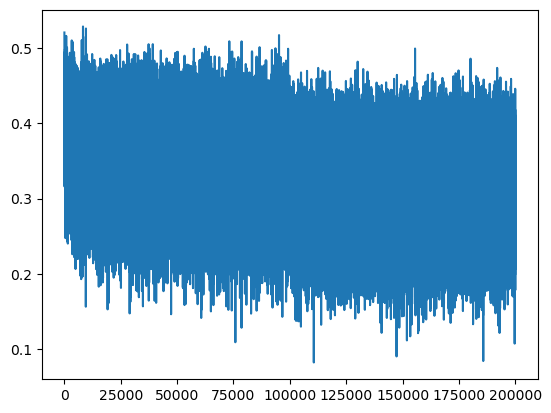

In [25]:
plt.plot(lossi);

We can see in loss plot, the curve bend is squashed after initialising output layer and bias to uniform values.

In [26]:
split_loss('train')
split_loss('val')

train 2.068942070007324
val 2.129626750946045


Train loss has improved from 2.17 to 2.06 because, training has not wasted any time squashing the weights and has looked at the data for additional 10000 steps.

Initialisation has improved initial loss

## Fixing saturated tanh

Logits are now okay, but let's explore h.

#

In [27]:
h

tensor([[-0.9999,  0.5069, -1.0000,  ...,  0.9958, -0.9996,  0.9994],
        [ 0.2820,  0.2718,  0.9532,  ..., -1.0000,  0.9991,  1.0000],
        [-1.0000, -0.9936, -1.0000,  ...,  1.0000, -0.9997, -0.9557],
        ...,
        [ 0.8435, -0.9986, -1.0000,  ...,  1.0000, -0.9982,  1.0000],
        [-1.0000, -0.7951, -0.9999,  ...,  0.9997, -0.9192,  1.0000],
        [-1.0000, -0.9999,  0.0653,  ..., -1.0000,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

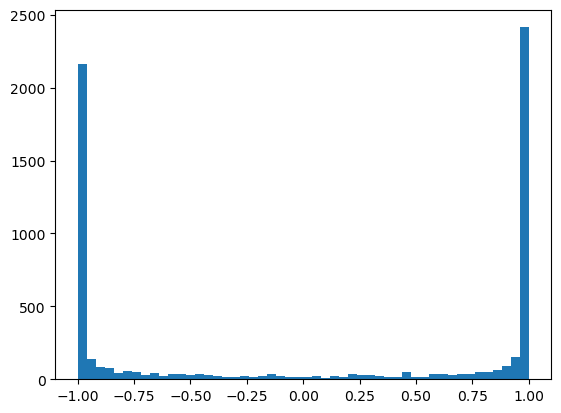

In [29]:
# visualizing h
plt.hist(h.view(-1).tolist(), bins=50);

we can see most of the values take on -1 or 1, meaning tanh is active. And why this happens, let's take a look at pre activations.

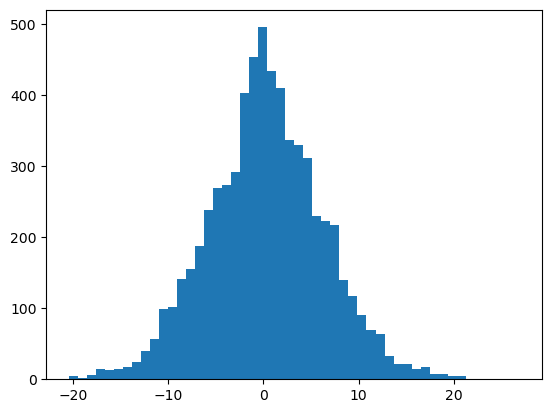

In [33]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

Since preactivations is really broad from -15 to 15 and that's why tanh takes values from -1 to 1.

And why this is a problem. Let's get into the details of it.

During backpropogations the gradients pass through tanh activation.

Grabbing element wise tanh from micrograd,

```Python
def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
```

When t(local gradient) is -1 or 1. self.grad becomes zero because `1 - (-1) ** 2, 1 - (1) ** 2` is `0`.
This is essentialy stopping backpropgation through this neuron beyond tanh.

Intutivley speaking, it tanh's output is close to 1. Changing the input is not going to impact output of tanh, since it's already in flat region of tanh(self.grad = 0). There's no impact on the loss.

So with respect to this input, we cannot impact the loss via backpropgation. The gradient will become zero and vanishes.

In another case, when t = 1 `1 - (0) ** 2` self.grad is out.grad. Meaning tanh unit is inactive and the gradient just passes through.

The gradient flowing through tanh only decreases and the amount it decrease here is proprtional to square (t**2).

> To conclude:
When the tanh output is in flat lands(-1, 1) the gradient vanishes and backpropgation is not effective.

In [35]:
1 - (-1) ** 2, 1 - (1) ** 2

(0, 0)

In [36]:
1 - (0) ** 2

1

Digging deeper into the problem, visualizing 200 tanh neurons across 32 inputs.

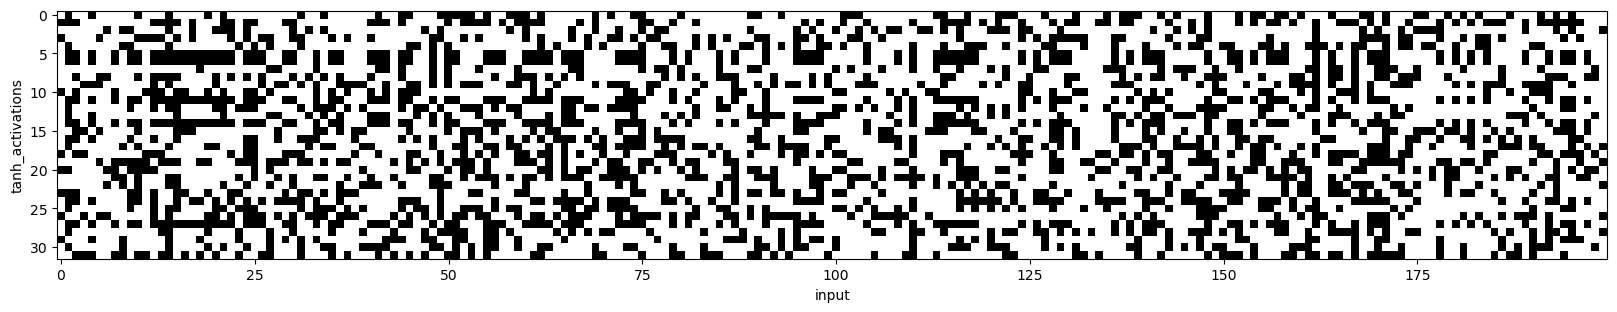

In [40]:
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

The plot above is boolean. Thw white dots it plot means tanh is very very active and in flat tail(-1, 1).
In all these cases backward gradient is destroyed.

We'll be in lot of trouble. For any one of these neurons,
If any one of the columns is completley white. In that case this becomes a dead neuron.

The initilisation of w and b is such that, no single input activates this neuron for any input. 
This is a case of dead neuron and it never learns.

This is the problem with saturated tanh(and other activations - sigmoid, relu).

The redeeming quality with this scenario is we don't have any such dead neurons and some gradient's will flow through and neurons will learn.

Another scenario of dead neurons will be during optimization.

Let's say the learning rate is high and the gradient is pushed off to flat tails of tanh or negative tail of relu. The gradients will be zero from that point and will become dead on future backpropgations.

This is called exploding gradients.

Leaky ReLu might not suffer much from thes issues, because of absence of flat parts in it's activation.

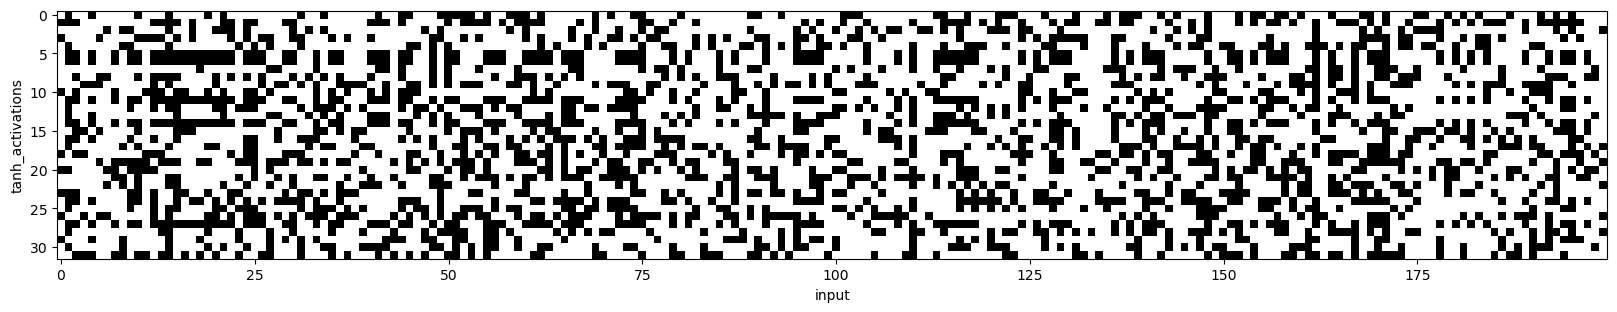

In [41]:
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

Going back to h, since we don't have any dead neurons. We should be okay, as the network optimizes and a pretty decent loss.
But this is not optimal and we don't want these extreme value during initialisation. `hpreact` is too extreme, leading to flat tails of tanh activations and less training for these neurons(because they update very less frequent)

embcat -> hpreact(too far from zero which is causing the issue)

We want't hpreact to be closer to 0.

In [70]:
# Reinit weights
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * 0.1
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Rerun first batch
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

Total number of parameters: 11897
      0/ 200000: 3.3018


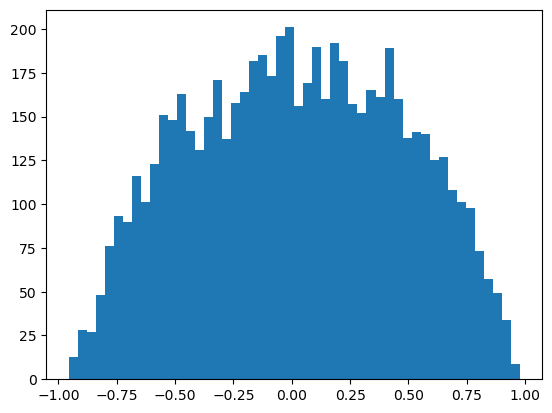

In [71]:
# Let's look at h distribution
plt.hist(h.view(-1).tolist(), bins=50);

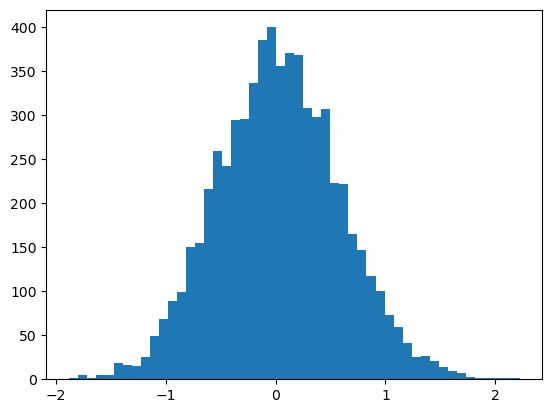

In [72]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

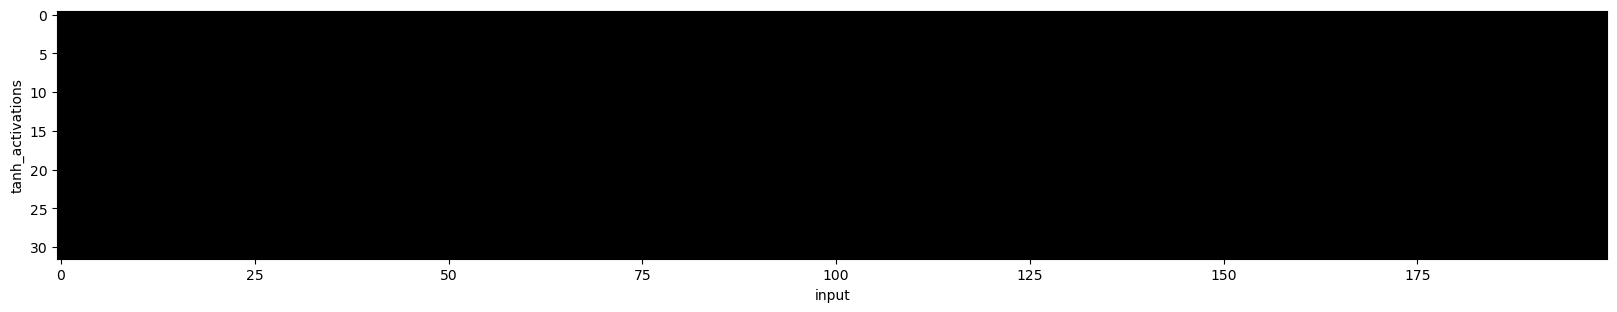

In [73]:
# And this should have less whites
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

In [74]:
# Reinit weights
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * 0.2
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Rerun first batch
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

Total number of parameters: 11897
      0/ 200000: 3.3070


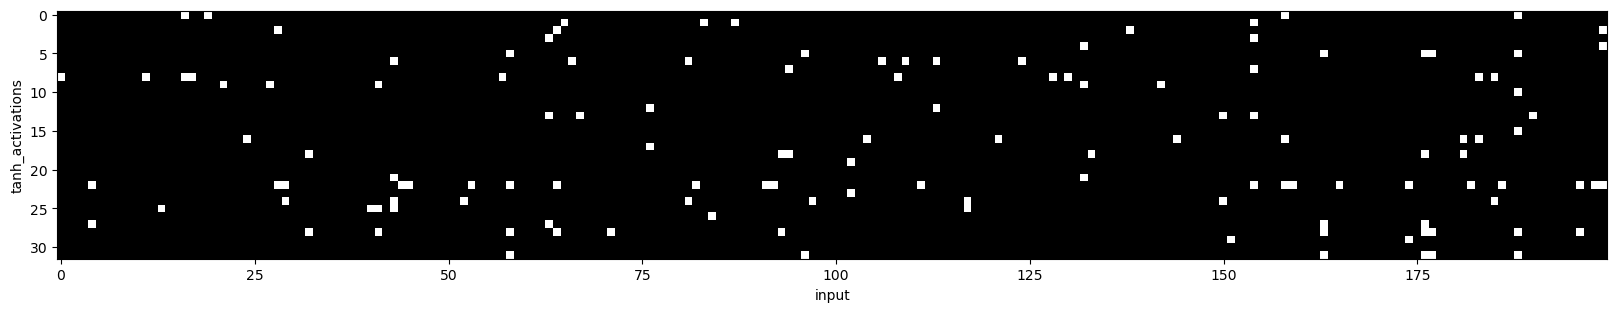

In [75]:
# And this should have less whites
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

In [76]:
# Reinit weights
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * 0.2
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 11897
      0/ 200000: 3.3070
  10000/ 200000: 2.0390
  20000/ 200000: 2.3337
  30000/ 200000: 2.1899
  40000/ 200000: 2.0281
  50000/ 200000: 2.3006
  60000/ 200000: 1.9184
  70000/ 200000: 2.0165
  80000/ 200000: 2.1462
  90000/ 200000: 2.0186
 100000/ 200000: 2.1868
 110000/ 200000: 2.0560
 120000/ 200000: 2.0876
 130000/ 200000: 1.6509
 140000/ 200000: 2.2062
 150000/ 200000: 2.2495
 160000/ 200000: 2.0697
 170000/ 200000: 1.6954
 180000/ 200000: 2.5340
 190000/ 200000: 2.2555


In [77]:
split_loss('train')
split_loss('val')

train 2.036576986312866
val 2.1043293476104736


Losses after initial loss fix

* train 2.068942070007324
* val 2.129626750946045

Losses after tanh saturation fix 

* train 2.036576986312866
* val 2.1043293476104736

The loss is improved because. Network has more time to train and neurons are learning more frequently by avoiding vanishing and exploding gradients.

Since this is a single layer mlp, the initialisation problem was not big issue. But for bigger networks with lots of layers.
These problems will stack up and without proper intilisation the model will not train at all.